In [66]:
#!/usr/bin/env python
# coding: utf-8

# # Exploratory Data Analysis (EDA)

# This notebook focuses on loading the cleaned CSV files, verifying their structure,
# and performing initial exploratory analysis such as examining data distributions,
# basic statistics, and sample visualizations.

In [36]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

# Scikit-learn Modules
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# XGBoost
import xgboost as xgb

# PyTorch Modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


In [ ]:
# Define the project root explicitly
project_root = Path("/Users/abdurrahman/Documents/Data Bootcamp/Finals/Predicting_Telework_Hours")
os.chdir(project_root)
print("New Working Directory:", os.getcwd())
print("Path.cwd():", Path.cwd())

# Set base path to 'data/cleaned' within the project
base_path = project_root / "data" / "cleaned"
print("Base Path:", base_path)

# Verify base path
if not base_path.exists():
    raise FileNotFoundError(f"Base path does not exist: {base_path}")
print("Contents of Base Path:", list(base_path.iterdir()))

# Function to load CSV files
def load_csv_tables(base_path, file_names):
    tables = {}
    for file_name in file_names:
        file_path = base_path / file_name
        if file_path.exists():
            table_name = file_path.stem  # Extracts the filename without extension
            tables[table_name] = pd.read_csv(file_path)
            print(f"Loaded: {file_name}")
        else:
            print(f"File not found: {file_path}")
    return tables

# File names
file_names = [
    'table_1_refined.csv',
    'table_2_refined.csv',
    'table_3_refined.csv',
    'table_4_refined.csv',
    'table_5_refined.csv',
    'table_6_refined.csv',
    'table_7_refined.csv',
    'table_8_refined.csv'
]

# Load tables
tables = load_csv_tables(base_path, file_names)

# Verify loaded tables
if not tables:
    print("WARNING: No tables were loaded. Please check file paths.")
else:
    print("Tables Loaded:", list(tables.keys()))

# --- Cleaning Table 8 ---

# Check if 'table_8_refined' exists in tables
if 'table_8_refined' in tables:
    table_8 = tables['table_8_refined']
    
    # Remove the first row (index 0) as it contains duplicated headers
    table_8_corrected = table_8.drop(index=0).reset_index(drop=True)
    print("Removed the duplicated header row from table_8.")

    # Define a corrected mapping for renaming columns
    rename_mapping_corrected = {
        'Unnamed: 0': 'Characteristic',
        'Unnamed: 1': 'Total_Teleworked_Worked_Home',
        'Unnamed: 2': 'Teleworked_Some_Hours_Count',
        'Unnamed: 3': 'Teleworked_All_Hours_Count',
        'Unnamed: 4': 'Hours_17_to_24',
        'Unnamed: 5': 'Hours_25_to_32',
        'Unnamed: 6': 'Hours_33_to_39',
        'Unnamed: 7': 'Total_Hours',
        'Unnamed: 8': 'Hours_40',
        'Unnamed: 9': 'Hours_41_or_More',
        'Unnamed: 10': 'Average_Weekly_Hours_Teleworked',
        'Unnamed: 11': 'Total_Percent',
        'Unnamed: 12': 'Hours_Up_to_8',
        'Unnamed: 13': 'Hours_9_to_16',
        'Unnamed: 14': 'Hours_17_to_24_Percent',
        'Unnamed: 15': 'Hours_25_to_32_Percent',
        'Unnamed: 16': 'Hours_33_to_39_Percent',
        'Unnamed: 17': 'Total_Percent_2',
        'Unnamed: 18': 'Hours_40_Percent',
        'Unnamed: 19': 'Hours_41_or_More_Percent'
    }
    
    # Apply the corrected renaming
    table_8_corrected.rename(columns=rename_mapping_corrected, inplace=True)
    print("--- Correctly Renamed Columns for Table 8 ---")
    print(table_8_corrected.columns, "\n")
    
    # Assign the corrected DataFrame back to the tables dictionary
    tables['table_8_refined'] = table_8_corrected
else:
    print("WARNING: 'table_8_refined' not found in loaded tables.")

# Optional: Verify the first few rows of the cleaned table
if 'table_8_refined' in tables:
    print("--- Preview of Cleaned Table 8 ---")
    print(tables['table_8_refined'].head())


New Working Directory: /Users/abdurrahman/Documents/Data Bootcamp/Finals/Predicting_Telework_Hours
Path.cwd(): /Users/abdurrahman/Documents/Data Bootcamp/Finals/Predicting_Telework_Hours
Base Path: /Users/abdurrahman/Documents/Data Bootcamp/Finals/Predicting_Telework_Hours/data/cleaned
Contents of Base Path: [PosixPath('/Users/abdurrahman/Documents/Data Bootcamp/Finals/Predicting_Telework_Hours/data/cleaned/table_5_refined.csv'), PosixPath('/Users/abdurrahman/Documents/Data Bootcamp/Finals/Predicting_Telework_Hours/data/cleaned/table_3_refined.csv'), PosixPath('/Users/abdurrahman/Documents/Data Bootcamp/Finals/Predicting_Telework_Hours/data/cleaned/table_6_refined.csv'), PosixPath('/Users/abdurrahman/Documents/Data Bootcamp/Finals/Predicting_Telework_Hours/data/cleaned/table_1_refined.csv'), PosixPath('/Users/abdurrahman/Documents/Data Bootcamp/Finals/Predicting_Telework_Hours/data/cleaned/table_8_refined.csv'), PosixPath('/Users/abdurrahman/Documents/Data Bootcamp/Finals/Predicting_Te

In [43]:
# List of columns that should be numeric
numeric_columns = [
    'Total_Teleworked_Worked_Home',
    'Weekly hours teleworked or worked at home for pay',  # Corrected column name
    'Teleworked_All_Hours_Count',
    'Hours_17_to_24',
    'Hours_25_to_32',
    'Hours_33_to_39',
    'Total_Hours',
    'Hours_40',
    'Hours_41_or_More',
    'Average_Weekly_Hours_Teleworked',
    'Total_Percent',
    'Hours_Up_to_8',
    'Hours_9_to_16',
    'Hours_17_to_24_Percent',
    'Hours_25_to_32_Percent',
    'Hours_33_to_39_Percent',
    'Total_Percent_2',
    'Hours_40_Percent',
    'Hours_41_or_More_Percent'
]

# Convert columns to numeric, coercing errors to NaN
for col in numeric_columns:
    tables['table_8_refined'][col] = pd.to_numeric(tables['table_8_refined'][col], errors='coerce')

# Initialize the imputer with median strategy
imputer = SimpleImputer(strategy='median')

# Fit and transform the data
tables['table_8_refined'][numeric_columns] = imputer.fit_transform(tables['table_8_refined'][numeric_columns])


In [45]:
# Rename columns in Table 1
table_1 = tables['table_1_refined'].copy()
table_1 = table_1.rename(columns={
    'Total persons  at work1': 'Total_Persons_At_Work',
    'Teleworked some hours2': 'Teleworked_Some_Hours',
    'Teleworked all hours': 'Teleworked_All_Hours',
    'Persons who did not telework or work at home for pay': 'Did_Not_Telework',
    'Total persons  at work1.1': 'Total_Persons_At_Work_Percent',
    'Total.1': 'Total_Teleworked_Worked_Home_Percent',
    'Teleworked some hours2.1': 'Teleworked_Some_Hours_Percent',
    'Teleworked all hours.1': 'Teleworked_All_Hours_Percent',
    'Persons who did not telework or work at home for pay.1': 'Did_Not_Telework_Percent'
})

# Select relevant columns
age_df = table_1[['Characteristic', 'Total_Persons_At_Work', 'Total',
                 'Teleworked_Some_Hours', 'Teleworked_All_Hours',
                 'Did_Not_Telework', 'Total_Persons_At_Work_Percent',
                 'Total_Teleworked_Worked_Home_Percent', 'Teleworked_Some_Hours_Percent',
                 'Teleworked_All_Hours_Percent', 'Did_Not_Telework_Percent']]


In [46]:
# Define features and target
X_age = age_df[['Total_Persons_At_Work', 'Teleworked_Some_Hours',
               'Teleworked_All_Hours', 'Did_Not_Telework']]
y_age = age_df['Average_Weekly_Hours_Teleworked'] if 'Average_Weekly_Hours_Teleworked' in age_df.columns else age_df['Teleworked_Some_Hours_Percent']  # Adjust based on actual column

# Check if 'Average_Weekly_Hours_Teleworked' exists
if 'Average_Weekly_Hours_Teleworked' not in age_df.columns:
    print("Note: 'Average_Weekly_Hours_Teleworked' not found in Table 1. Using 'Teleworked_Some_Hours_Percent' as target.")
    y_age = age_df['Teleworked_Some_Hours_Percent']


Note: 'Average_Weekly_Hours_Teleworked' not found in Table 1. Using 'Teleworked_Some_Hours_Percent' as target.


In [47]:
# Rename columns in Table 2
table_2 = tables['table_2_refined'].copy()
table_2 = table_2.rename(columns={
    'Total persons  at work1': 'Total_Persons_At_Work',
    'Teleworked some hours2': 'Teleworked_Some_Hours',
    'Teleworked all hours': 'Teleworked_All_Hours',
    'Persons who did not telework or work at home for pay': 'Did_Not_Telework',
    'Total persons  at work1.1': 'Total_Persons_At_Work_Percent',
    'Total.1': 'Total_Teleworked_Worked_Home_Percent',
    'Teleworked some hours2.1': 'Teleworked_Some_Hours_Percent',
    'Teleworked all hours.1': 'Teleworked_All_Hours_Percent',
    'Persons who did not telework or work at home for pay.1': 'Did_Not_Telework_Percent'
})

# Select relevant columns
employment_df = table_2[['Characteristic', 'Total_Persons_At_Work', 'Total',
                         'Teleworked_Some_Hours', 'Teleworked_All_Hours',
                         'Did_Not_Telework', 'Total_Persons_At_Work_Percent',
                         'Total_Teleworked_Worked_Home_Percent', 'Teleworked_Some_Hours_Percent',
                         'Teleworked_All_Hours_Percent', 'Did_Not_Telework_Percent']]


In [48]:
# Define features and target
X_employment = employment_df[['Total_Persons_At_Work', 'Teleworked_Some_Hours',
                             'Teleworked_All_Hours', 'Did_Not_Telework']]
y_employment = employment_df['Average_Weekly_Hours_Teleworked'] if 'Average_Weekly_Hours_Teleworked' in employment_df.columns else employment_df['Teleworked_Some_Hours_Percent']  # Adjust based on actual column

# Check if 'Average_Weekly_Hours_Teleworked' exists
if 'Average_Weekly_Hours_Teleworked' not in employment_df.columns:
    print("Note: 'Average_Weekly_Hours_Teleworked' not found in Table 2. Using 'Teleworked_Some_Hours_Percent' as target.")
    y_employment = employment_df['Teleworked_Some_Hours_Percent']


Note: 'Average_Weekly_Hours_Teleworked' not found in Table 2. Using 'Teleworked_Some_Hours_Percent' as target.


In [49]:
# Rename columns in Table 3
table_3 = tables['table_3_refined'].copy()
table_3 = table_3.rename(columns={
    'Number of persons (in thousands)': 'Number_Persons_Thousands',
    'Average weekly hours teleworked or worked at home for pay': 'Avg_Weekly_Hours_Teleworked',
    'Average weekly hours worked': 'Avg_Weekly_Hours_Worked',
    'Hours teleworked or worked at home for pay as a percent of hours worked2': 'Telework_Hours_Percent',
    'Number of persons (in thousands).1': 'Teleworked_Hours_Thousands',
    'Average weekly hours teleworked or worked at home for pay.1': 'Avg_Weekly_Hours_Teleworked_1',
    'Average weekly hours worked.1': 'Avg_Weekly_Hours_Worked_1',
    'Hours teleworked or worked at home for pay as a percent of hours worked2.1': 'Telework_Hours_Percent_1'
})

# Select relevant columns
telework_df = table_3[['Characteristic', 'Number_Persons_Thousands', 'Avg_Weekly_Hours_Teleworked',
                       'Avg_Weekly_Hours_Worked', 'Telework_Hours_Percent']]

telework_percent_df = table_3[['Characteristic', 'Telework_Hours_Percent_1']]

# Merge counts and percentages
telework_combined_df = telework_df.merge(telework_percent_df, on='Characteristic')


In [55]:
# Define a mapping from existing column names to desired column names for table_4
rename_mapping_table4 = {
    'Number of persons (in thousands)': 'Teleworked_Hours_Thousands',
    'Average weekly hours teleworked or worked at home for pay': 'Avg_Weekly_Hours_Teleworked',
    'Average weekly hours worked': 'Avg_Weekly_Hours_Worked',
    'Hours teleworked or worked at home for pay as a percent of hours worked2': 'Telework_Hours_Percent',
    'Number of persons (in thousands).1': 'Teleworked_Hours_Thousands_1',
    'Average weekly hours teleworked or worked at home for pay.1': 'Avg_Weekly_Hours_Teleworked_1',
    'Average weekly hours worked.1': 'Avg_Weekly_Hours_Worked_1',
    'Hours teleworked or worked at home for pay as a percent of hours worked2.1': 'Telework_Hours_Percent_1'
}

# Rename columns in table_4
if 'table_4_refined' in tables:
    tables['table_4_refined'].rename(columns=rename_mapping_table4, inplace=True)
    print("Renamed columns in table_4 successfully.")
    
    # Display the renamed columns
    print("--- Renamed Columns in table_4 ---")
    print(tables['table_4_refined'].columns)
    
    # Define the columns you want to select
    desired_columns_table4 = [
        'Characteristic',
        'Teleworked_Hours_Thousands',
        'Avg_Weekly_Hours_Teleworked',
        'Avg_Weekly_Hours_Worked',
        'Telework_Hours_Percent',
        'Telework_Hours_Percent_1'
    ]

    # Verify that all desired columns exist
    missing_columns = [col for col in desired_columns_table4 if col not in tables['table_4_refined'].columns]
    if missing_columns:
        print(f"Warning: The following columns are missing in table_4 and will be skipped: {missing_columns}")
        # Remove missing columns from the list
        desired_columns_table4 = [col for col in desired_columns_table4 if col in tables['table_4'].columns]

    # Select the relevant columns
    telework_df_table4 = tables['table_4_refined'][desired_columns_table4]
    print("Selected relevant columns from table_4:")
    print(telework_df_table4.head())
else:
    print("Error: 'table_4_refined.csv' was not loaded successfully.")


Renamed columns in table_4 successfully.
--- Renamed Columns in table_4 ---
Index(['Characteristic', 'Teleworked_Hours_Thousands', 'Avg_Weekly_Hours_Teleworked', 'Avg_Weekly_Hours_Worked', 'Telework_Hours_Percent', 'Teleworked_Hours_Thousands_1', 'Avg_Weekly_Hours_Teleworked_1', 'Avg_Weekly_Hours_Worked_1', 'Telework_Hours_Percent_1'], dtype='object')
Selected relevant columns from table_4:
                                      Characteristic  Teleworked_Hours_Thousands  Avg_Weekly_Hours_Teleworked  Avg_Weekly_Hours_Worked  Telework_Hours_Percent Telework_Hours_Percent_1
0                           Total, 16 years and over                      157329                          6.3                     38.6                    16.4                     66.6
1                                  Full-time workers                      130756                          7.1                     42.2                    16.8                       66
2                                  Part-time workers  

In [56]:
# Rename 'Characteristic' to 'Employment_Status_Occupation' in telework_df_table4
telework_df_table4 = telework_df_table4.rename(columns={'Characteristic': 'Employment_Status_Occupation'})

# Rename 'Characteristic' to 'Employment_Status_Occupation' in employment_df
employment_df_renamed = employment_df.rename(columns={'Characteristic': 'Employment_Status_Occupation'})

# Merge employment_df_renamed with telework_df_table4 on 'Employment_Status_Occupation'
merged_emp_df = pd.merge(employment_df_renamed, telework_df_table4,
                         on='Employment_Status_Occupation', how='left')

# One-Hot Encode 'Employment_Status_Occupation'
merged_emp_df_encoded = pd.get_dummies(merged_emp_df,
                                      columns=['Employment_Status_Occupation'],
                                      drop_first=True)

# Display the encoded DataFrame
print("--- Merged Employment DataFrame After One-Hot Encoding ---")
print(merged_emp_df_encoded.head(), "\n")

--- Merged Employment DataFrame After One-Hot Encoding ---
   Total_Persons_At_Work  Total  Teleworked_Some_Hours  Teleworked_All_Hours  Did_Not_Telework  Total_Persons_At_Work_Percent  Total_Teleworked_Worked_Home_Percent  Teleworked_Some_Hours_Percent  Teleworked_All_Hours_Percent  Did_Not_Telework_Percent  Teleworked_Hours_Thousands  Avg_Weekly_Hours_Teleworked  Avg_Weekly_Hours_Worked  Telework_Hours_Percent Telework_Hours_Percent_1  Employment_Status_Occupation_Management, professional, and related occupations  Employment_Status_Occupation_Natural resources, construction, and maintenance occupations  Employment_Status_Occupation_Nonagricultural industries  Employment_Status_Occupation_Production, transportation, and material moving occupations  Employment_Status_Occupation_Sales and office occupations  Employment_Status_Occupation_Self-employed workers  Employment_Status_Occupation_Service occupations  Employment_Status_Occupation_Total, 16 years and over  \
0                 1573

In [57]:
# Replace '-' with NaN in 'Telework_Hours_Percent_1'
merged_emp_df_encoded['Telework_Hours_Percent_1'] = merged_emp_df_encoded['Telework_Hours_Percent_1'].replace('-', np.nan)

# Convert 'Telework_Hours_Percent_1' to numeric, forcing errors to NaN
merged_emp_df_encoded['Telework_Hours_Percent_1'] = pd.to_numeric(merged_emp_df_encoded['Telework_Hours_Percent_1'], errors='coerce')

# Initialize the imputer with median strategy
imputer_emp = SimpleImputer(strategy='median')

# Fit and transform 'Telework_Hours_Percent_1'
merged_emp_df_encoded['Telework_Hours_Percent_1'] = imputer_emp.fit_transform(merged_emp_df_encoded[['Telework_Hours_Percent_1']])

In [58]:
# Define the target variable
target_master = 'Avg_Weekly_Hours_Teleworked'
y_master = merged_emp_df_encoded[target_master]
print("--- y_master Defined ---")
print(y_master.head())
print("\n")

--- y_master Defined ---
0     6.3
1     7.1
2     2.6
3    10.4
4    12.9
Name: Avg_Weekly_Hours_Teleworked, dtype: float64




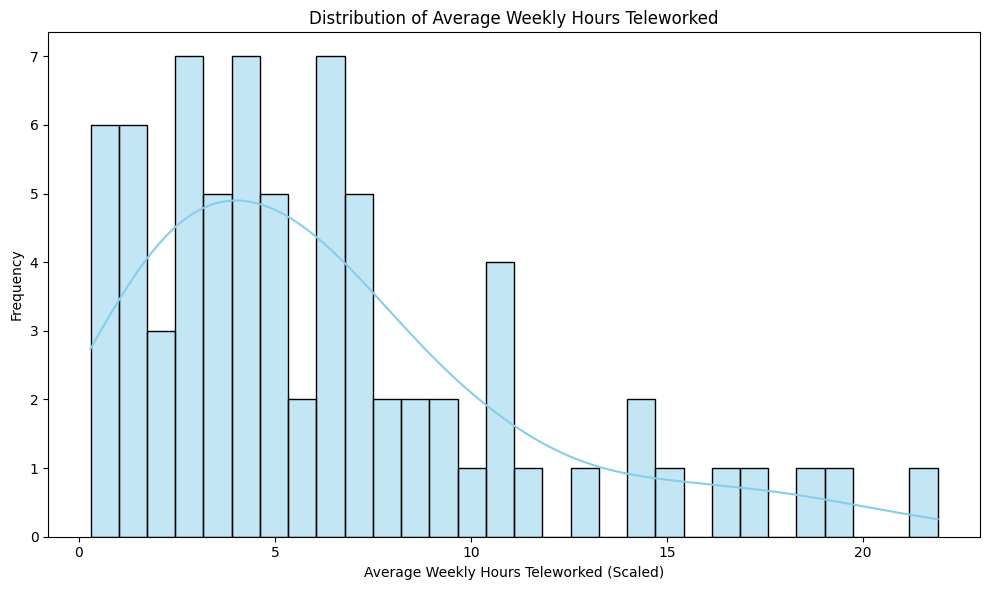

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'y_master' is your target variable
plt.figure(figsize=(10, 6))
sns.histplot(y_master, kde=True, bins=30, color='skyblue')
plt.title('Distribution of Average Weekly Hours Teleworked')
plt.xlabel('Average Weekly Hours Teleworked (Scaled)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('telework_hours_distribution.png')  # Save the figure
plt.show()


In [59]:
# List of numerical features after cleaning
numerical_features_emp = [
    'Teleworked_Hours_Thousands',
    'Avg_Weekly_Hours_Teleworked',
    'Avg_Weekly_Hours_Worked',
    'Telework_Hours_Percent',
    'Telework_Hours_Percent_1'
]

# Define the feature set by excluding only the target
features = merged_emp_df_encoded.drop([target_master], axis=1)
target = merged_emp_df_encoded['Avg_Weekly_Hours_Teleworked']

# Initialize the scaler
scaler_emp = StandardScaler()

# Fit and transform the numerical features
merged_emp_df_encoded[numerical_features_emp] = scaler_emp.fit_transform(merged_emp_df_encoded[numerical_features_emp])

# Save the scaler for future use
joblib.dump(scaler_emp, 'scaler_emp.pkl')

# Verify the scaling
print("--- Features After Scaling in Merged Employment DataFrame ---")
print(merged_emp_df_encoded[numerical_features_emp].head())
print("\n")

--- Features After Scaling in Merged Employment DataFrame ---
   Teleworked_Hours_Thousands  Avg_Weekly_Hours_Teleworked  Avg_Weekly_Hours_Worked  Telework_Hours_Percent  Telework_Hours_Percent_1
0                    3.994642                    -0.008057                 0.036332                0.007931                  0.393008
1                    3.220097                     0.156407                 1.065991                0.040994                  0.321901
2                    0.183387                    -0.768702                -5.083362               -0.306170                  1.435904
3                    1.417623                     0.834821                 0.436755                0.809714                  0.262646
4                    0.286104                     1.348771                 0.951584                1.206473                  0.464115




In [61]:
# Rename 'Characteristic' to 'Age_Group' in telework_df
telework_df = telework_df.rename(columns={'Characteristic': 'Age_Group'})


In [62]:
# Create a directory to save processed data
processed_data_path = project_root / "data" / "processed"
os.makedirs(processed_data_path, exist_ok=True)

# Save the merged and cleaned employment DataFrame
processed_data_file = processed_data_path / "merged_emp_df_encoded.csv"
merged_emp_df_encoded.to_csv(processed_data_file, index=False)
print(f"Saved processed data to {processed_data_file}")

Saved processed data to /Users/abdurrahman/Documents/Data Bootcamp/Finals/Predicting_Telework_Hours/data/processed/merged_emp_df_encoded.csv


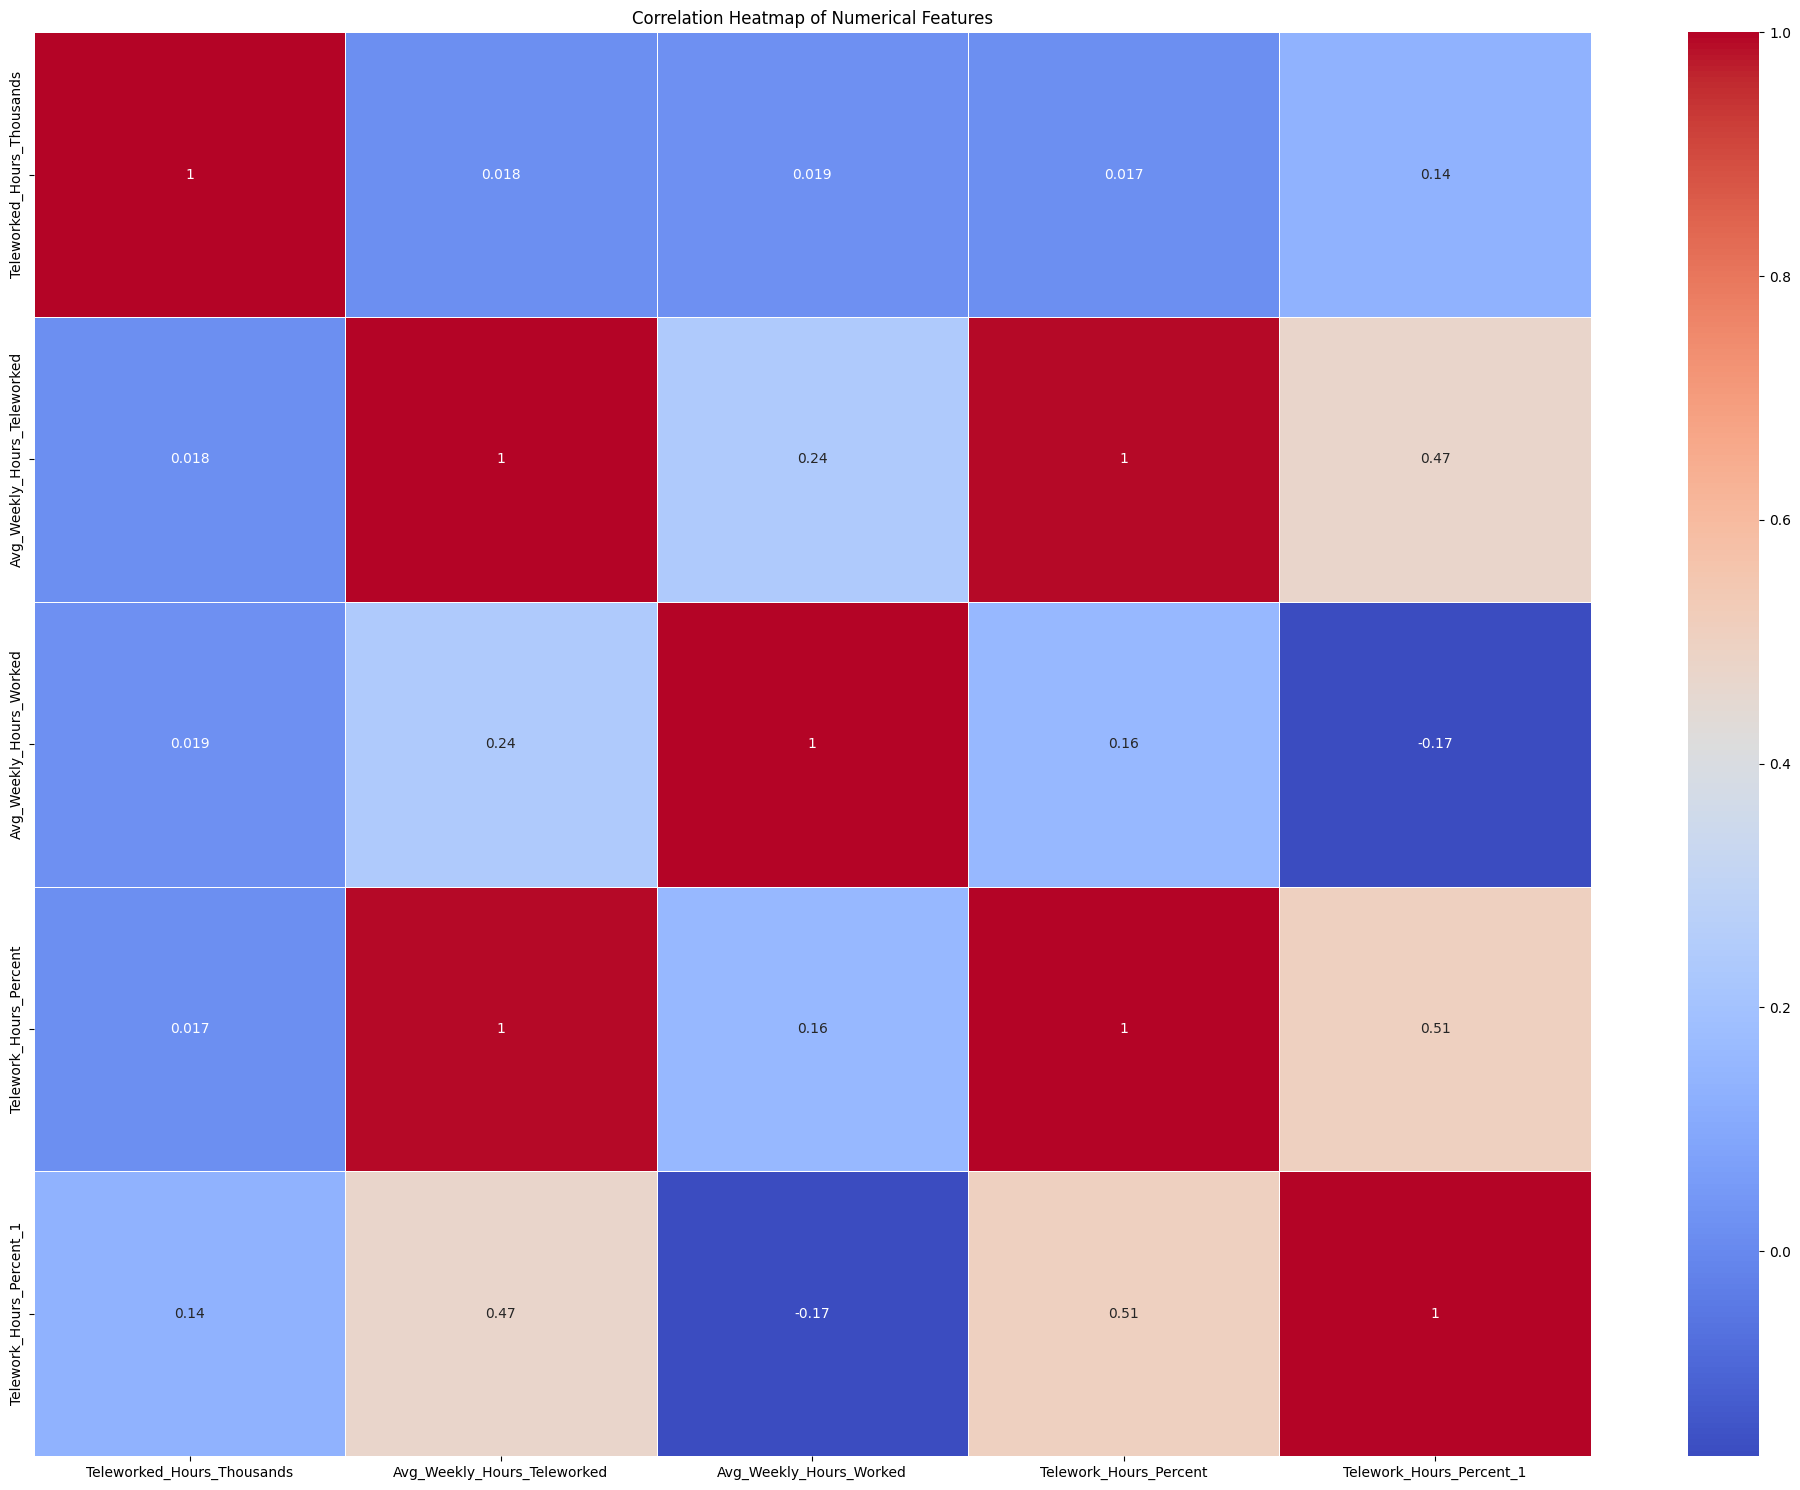

In [64]:
plt.figure(figsize=(20, 15))
correlation_matrix = merged_emp_df_encoded[numerical_features_emp].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')  # Save the figure
plt.show()
